# CW ODMR

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import time
import logging

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import qcsapphire
import qt3rfsynthcontrol
import qt3utils.experiments.cwodmr
import qt3utils.nidaq

##  Set Logging Levels

In [5]:
logging.basicConfig(level=logging.WARNING)
qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)

# Create objects to control hardware

In [6]:
qcsapphire.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM4',
  'USB Serial Device (COM4)',
  'USB VID:PID=04D8:000A SER= LOCATION=1-10:x.0'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-9:x.0'],
 ['COM6',
  'piezojena NV40/3CL USB (COM6)',
  'USB VID:PID=0403:D161 SER=714151A'],
 ['COM7',
  'USB Serial Device (COM7)',
  'USB VID:PID=239A:8014 SER=3B0D07C25831555020312E341A3214FF LOCATION=1-5:x.0']]

In [7]:
pulser = qcsapphire.Pulser('COM4')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [8]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

# Instantiate an experiment object

In [19]:
experiment = qt3utils.experiments.cwodmr.CWODMR(pulser, rfsynth, nidaq_config,
                                            photon_counter_nidaq_terminal = 'PFI0',
                                            clock_nidaq_terminal = 'PFI12',
                                            trigger_nidaq_terminal = 'PFI1',
                                            freq_low=2700e6,
                                            freq_high=3000e6,
                                            freq_step=2e6,
                                            rf_power=-10)

In [10]:
experiment.experimental_conditions()

{'freq_low': 2700000000.0,
 'freq_high': 3000000000.0,
 'freq_step': 2000000.0,
 'rf_power': -10,
 'rf_width': 5e-06,
 'clock_period': 2e-07}

# Change conditions if desired

In [11]:
#cwodmr.freq_low = 2500e6
#cwodmr.freq_high = 3200e6
#cwodmr.freq_step = 1e6
#cwodmr.rf_power
#cwodmr.rf_width

# Take Data

In [12]:
scan_data = experiment.run(N_cycles=10000)

# scan_data is a list where each element of the list is the result of the CWODMR data acquired at a particular frequency.

# Each element of scan_data contains a list of size two. The first element is the frequency, the second element is 
# an array of data that is the output of the aggregation of the full raw data stream. The size of this array of data
# will be equal to cwodmr.N_clock_ticks_per_cycle

# scan_data - [
#   [2700e6, [d_1, d_2, d_3, ... d_N_clock_ticks_per_cycle]],
#   [2705e6, [d_1, d_2, d_3, ... d_N_clock_ticks_per_cycle]]
#   ...
#   [3000e6, [d_1, d_2, d_3, ... d_N_clock_ticks_per_cycle]]

# ]


INFO:qt3utils.experiments.cwodmr:RF frequency: 2700000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2702000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2704000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2706000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2708000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2710000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2712000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2714000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2716000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2718000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2720000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2722000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2724000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2726000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2728000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27300000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2962000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2964000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2966000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2968000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2970000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2972000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2974000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2976000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2978000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2980000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2982000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2984000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2986000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2988000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2990000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29920000

# Check out the data

In [13]:
def plot_trace(trace, N_cycles=1, clock_rate=1, label = None):
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate, label = label)

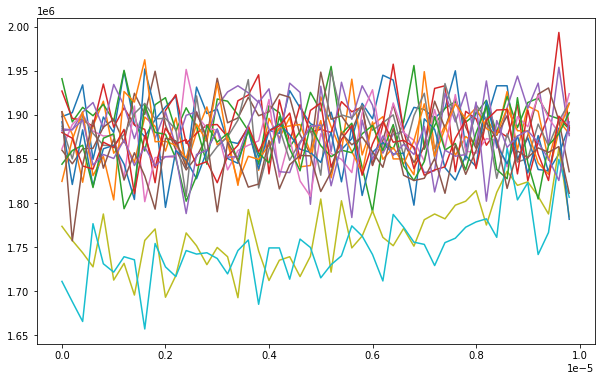

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

for scan in scan_data[::10]:
    
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.clock_period, label = scan[0])
    
# for freq in list(combined_scans.keys())[::5]:
#     plot_trace(combined_scans[freq], cwodmr.N_cycles, clock_rate = 1./cwodmr.clock_period)

In [15]:
def plot_frequency(scan_data,  freq = 2870e6):
    frequencies = np.array([x[0] for x  in scan_data ])
    res_index = np.where(np.isclose(frequencies,freq))
    scan = scan_data[int(res_index[0])]
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.clock_period, label = scan[0])

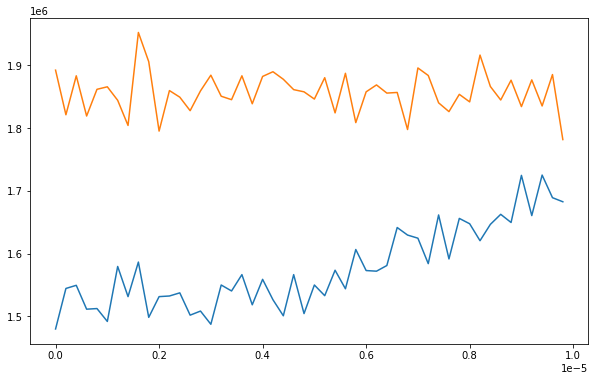

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

# on resonance
plot_frequency(scan_data, 2870e6)

# off resonance
plot_frequency(scan_data, 2900e6)

# Plot Scan

In [26]:
def build_contrast(scan_data):
    #stack the traces into a 2d array 
    two_d_scan_data = np.array([scan[-1] for scan in scan_data])
    
    
    frequencies = np.array([scan[0] for scan in scan_data]) #array of frequency values
    
    #for the scan at each frequency, during the first half of the trace, the RF/MW was on, and is therefore our signal
    len_of_trace = two_d_scan_data.shape[1]
    
    signal = two_d_scan_data[:,:len_of_trace//2].mean(axis=1) #signal is now a 1D array, with values of mean cts/sec for each frequency
    
    #the RF/MW was turned off during the 2nd half of the trace
    background = two_d_scan_data[:,len_of_trace//2:].mean(axis=1)
    
    return frequencies, signal/background

def plot_scan(scan_data, ax = None, label = None):
    f, c = build_contrast(scan_data)
    
    #if you don't understand the syntax above, look into "slicing" of numpy arrays
    if ax:
        ax.plot(f, c, '-', label = label)
    else:
        plt.plot(f, c, '-', label = label)
    

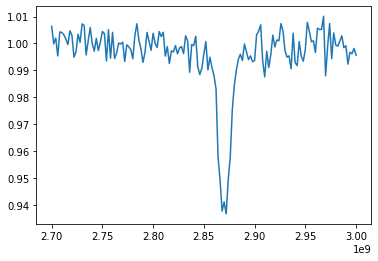

In [27]:
#plt.scatter(np.array([scan[0] for scan in scan_data_1x]), signal/background, s=5)
plot_scan(scan_data)

In [20]:
qt3utils.experiments.cwodmr.logger.setLevel(logging.WARNING)

In [21]:
scans = {}
for rf_power in [-30, -20, -10, 0]:
    print(f'power: {rf_power}')
    experiment.rf_power = rf_power
    scan_data = experiment.run(N_cycles=10000)
    scans[rf_power] = scan_data

power: -30
power: -20
power: -10
power: 0


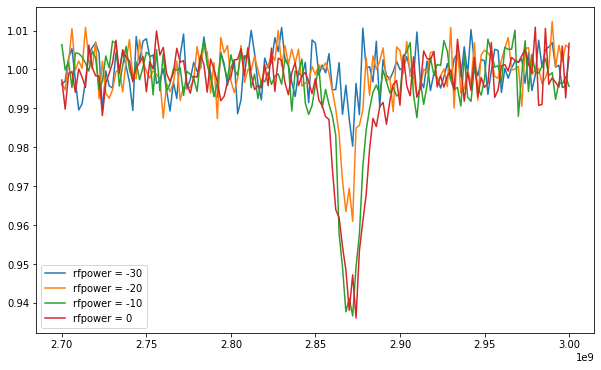

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

for rfp, scan_data in scans.items():
    plot_scan(scan_data, ax, f'rfpower = {rfp}')
    
ax.legend()

In [28]:
scan_data = scans[-10]

In [29]:
f, c = build_contrast(scan_data)

In [32]:
f[np.argmin(c)]

2872000000.0

In [33]:
np.min(c)

0.9366598903468244